In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
def B(t, T, kappa):
    delta_time = (T - t) / 12
    return (1 - np.exp(-kappa * delta_time)) / kappa

In [3]:
def B_theta_Riemann_sum(t, T, theta, kappa):
    riemann_sum = 0
    ds = 1.0 / 12
    for s in range(t, T):
        riemann_sum += B(s, T, kappa) * theta * ds
    return riemann_sum

In [4]:
def A(t, T, theta, kappa, sigma):
    delta_time = (T - t) / 12
    a_1 = B_theta_Riemann_sum(t, int(T), theta, kappa)
    a_2 = sigma ** 2 / (2 * kappa ** 2) * (delta_time + (1 - np.exp(- 2 * kappa * delta_time)) / (2 * kappa) - 2 * B(t, T, kappa))
    return -a_1 + a_2

In [5]:
def calc_future_spot_rates(tau_years, short_rates, t, theta, kappa, sigma):
    """Calculate the future spot rates. For example, in t months what is the tau_years spot rate."""
    tau_months = 12.0 * tau_years
    ten_year_rate = -A(t, t + tau_months, theta, kappa, sigma) / tau_years + (1 / kappa) * ((1 - np.exp(-kappa * tau_years)) / tau_years) * short_rates
    return ten_year_rate

In [6]:
def construct_future_spot_rate_matrix(tau_years, spot_rates, theta, kappa, sigma, num_periods):
    num_simulations = spot_rates.shape[0]
    tau_year_rates = np.zeros((num_simulations, num_periods))
    for time_idx in range(num_periods):
        tau_year_rates[:, time_idx] = calc_future_spot_rates(tau_years, spot_rates[:, time_idx], time_idx, theta, kappa, sigma)
    return tau_year_rates

In [7]:
def simulate_antithetic_short_rates(num_paths, num_months, theta, kappa, sigma, inital_r=0, seed=102):
    np.random.seed(seed)
    draws = np.random.normal(size=(num_paths, num_months))
    dt = 1/12
    dr_pos = np.zeros((num_paths, num_months+1))
    r_pos = np.zeros((num_paths, num_months+1))
    dr_neg = np.zeros((num_paths, num_months+1))
    r_neg = np.zeros((num_paths, num_months+1))
    r_pos[:, 0] = inital_r
    r_neg[:, 0] = inital_r

    for i in range(num_months):
        dr_pos[:,i] = (theta - kappa*r_pos[:,i])*dt + sigma*dt**0.5*draws[:,i]
        dr_neg[:,i] = (theta - kappa*r_neg[:,i])*dt - sigma*dt**0.5*draws[:,i]
        r_pos[:,i+1] = r_pos[:,i] + dr_pos[:,i]
        r_neg[:,i+1] = r_neg[:,i] + dr_neg[:,i]

    return  r_pos, r_neg

In [8]:
# Simulation Parameters
N = 10000  # num simulations
T = 360  # months
COUPON_GAP_YEARS = 10  # years

# Hull-White Parameters
short_rate_on_august_30_2004 = 1.45 / 100
theta = 0.004624
kappa = 0.114676
sigma = 0.01456

# calculate discount factors
short_rates, short_rates_anti = simulate_antithetic_short_rates(N, T, theta, kappa, sigma, short_rate_on_august_30_2004)
discount_factors = np.cumprod(np.exp(-short_rates / 12), axis=1)
discount_factors_anti = np.cumprod(np.exp(-short_rates_anti / 12), axis=1)

# calculate 10 year rates
future_spot_rates = construct_future_spot_rate_matrix(COUPON_GAP_YEARS, short_rates, theta, kappa, sigma, T)
future_spot_rates_anti = construct_future_spot_rate_matrix(COUPON_GAP_YEARS, short_rates_anti, theta, kappa, sigma, T)

print("Short Rates:\n")
print(short_rates)

print("Discount Factors: \n")
print(discount_factors)

print("Future 10 year spot rates: \n")
print(future_spot_rates)

Short Rates:

[[0.0145     0.02175784 0.02582675 ... 0.0494502  0.04897685 0.04764405]
 [0.0145     0.0146151  0.01215458 ... 0.03519174 0.03540605 0.03786092]
 [0.0145     0.02175486 0.01914737 ... 0.06656438 0.0631917  0.06394562]
 ...
 [0.0145     0.01734244 0.01986712 ... 0.038395   0.03711054 0.03707522]
 [0.0145     0.01275488 0.01182277 ... 0.04390418 0.0393338  0.04371345]
 [0.0145     0.01516772 0.02137636 ... 0.05815533 0.0618319  0.05660191]]
Discount Factors: 

[[0.9987924  0.99698307 0.99483964 ... 0.30182887 0.30059949 0.29940838]
 [0.9987924  0.99757668 0.99656677 ... 0.32354726 0.32259404 0.32157783]
 [0.9987924  0.99698332 0.99539379 ... 0.38193389 0.37992793 0.37790875]
 ...
 [0.9987924  0.99734998 0.99570014 ... 0.27622662 0.2753737  0.27452422]
 [0.9987924  0.99773134 0.99674883 ... 0.53808878 0.53632791 0.53437774]
 [0.9987924  0.99753074 0.99575536 ... 0.29661671 0.29509228 0.29370366]]
Future 10 year spot rates: 

[[0.0234441  0.0277626  0.03018365 ... 0.04397939

----

### Coupon Gap (using 10 yr rates)

In [9]:
future_spot_rates.shape

(10000, 360)

In [10]:
fixed_rates = np.arange(0.025, 0.04, 0.0005)
fixed_rates

array([0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285,
       0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325,
       0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365,
       0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395])

In [11]:
def fixed_rates_per_loan(fixed_rates, num_loans = 30, months = 360):
    
    
    fixed_final = []
    for i in list(fixed_rates):
        fixed = []
        for j in range(0,months):
            fixed.append(i)
        fixed_final.append(fixed)
    
    return np.array(fixed_final)
    
    

In [12]:
fr = fixed_rates_per_loan(fixed_rates, num_loans =30, months=360)

In [17]:
fr.shape

(30, 360)

In [14]:
def coupon_gap_per_user(fixed_rates_per_loan, future_spot_rates):
    """fixed loan rate - 10 yr rate"""
    
    
    dataframes = []
    
    for user in range(0, fixed_rates_per_loan.shape[0]):
        
        coupon_gap = []
        
        for int_path in range(0,future_spot_rates.shape[0]):
            
            coupon_gap.append(list(fixed_rates_per_loan[user] - future_spot_rates[int_path]))
        
        df = pd.DataFrame(np.array(coupon_gap).T)
        dataframes.append(df)
        
    return dataframes
    

In [15]:
cg = coupon_gap_per_user(fr, future_spot_rates)

In [16]:
def date_coupon_gaps(list_of_user_frames, start_date, years):
    
    end_yr = str(int(start_date.split("-")[0])+years)
    end_date = end_yr+"-01-01"
    dates = pd.date_range(start_date, end_date, freq='MS' )
    
    for user in range(0, len(list_of_user_frames)):
        
        list_of_user_frames[user].index = dates[:-1]
        
    return list_of_user_frames
    

In [69]:
#num users

In [70]:
len(cg)

30

In [71]:
cg2 = date_coupon_gaps(cg, "2017-01-01", 30)

In [72]:
#loan/user 1 coupon gaps in 10000 possible states of the future

In [73]:
cg2[0].tail()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2046-08-01,-0.046298,-0.041032,-0.052967,-0.065091,-0.032467,-0.049948,-0.012855,-0.047055,-0.040709,-0.014677,...,-0.046087,-0.045323,-0.072523,-0.009772,-0.047165,-0.028728,-0.002348,-0.037877,-0.038825,-0.051338
2046-09-01,-0.044033,-0.038808,-0.052585,-0.063625,-0.031805,-0.052575,-0.013424,-0.048008,-0.039921,-0.014408,...,-0.045372,-0.046886,-0.071660,-0.010417,-0.048064,-0.028331,-0.000891,-0.041198,-0.039411,-0.052093
2046-10-01,-0.044709,-0.037036,-0.052642,-0.065740,-0.033219,-0.057067,-0.013157,-0.046024,-0.038673,-0.019006,...,-0.046053,-0.043249,-0.075420,-0.008219,-0.042935,-0.028555,0.001684,-0.042352,-0.037742,-0.049987
2046-11-01,-0.044974,-0.036491,-0.055158,-0.068023,-0.035123,-0.056625,-0.015255,-0.043405,-0.041888,-0.019734,...,-0.038861,-0.046814,-0.075774,-0.008755,-0.044530,-0.031134,-0.002902,-0.038397,-0.041675,-0.050154
2046-12-01,-0.044698,-0.036623,-0.053156,-0.064921,-0.035867,-0.053612,-0.017869,-0.045178,-0.038188,-0.016469,...,-0.035509,-0.048759,-0.075376,-0.007902,-0.043357,-0.030880,0.000595,-0.037637,-0.038960,-0.052347


In [79]:
import matplotlib.pyplot as plt

In [80]:
mean_r = np.mean(short_rates, axis=0)
std_r = np.std(short_rates, axis=0)

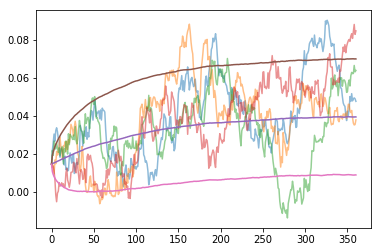

In [81]:
for i in range(4):
    plt.plot(short_rates[i, :], alpha=0.5)
plt.plot(mean_r)
plt.plot(mean_r+std_r)
plt.plot(mean_r-std_r)

In [77]:
short_rates.shape

(10000, 361)